### Base Line

In [330]:
from functools import partial
from IPython.display import display
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from utils import load, transform_datetime_features

Preprocessing

In [133]:
def constant_features(df_x):
    constant_columns = [
        col_name
        for col_name in df_x.columns
        if df_x[col_name].nunique() == 1
    ]
    return constant_columns

In [270]:
def drop_columns(df_x, cols):
    return df_x.drop(cols, axis=1)

In [135]:
def select_for_encoding(df_x, max_unique=20):
    categorical = {}
    for col_name in list(df_x.columns):
        col_unique_values = df_x[col_name].unique()
        if 2 < len(col_unique_values) <= max_unique:
            categorical[col_name] = col_unique_values
    return categorical

In [136]:
def one_hot_encoding(df_x, categorical):
    df_dummies = pd.DataFrame()
    for col_name, unique_values in categorical.items():
        for unique_value in unique_values:
            df_dummies[f'onehot_{col_name}={unique_value}'] = (df_x[col_name] == unique_value).astype(int)
    return pd.concat([df_x, df_dummies], axis=1)

In [171]:
def find_missings(df_x):
    columns_with_missings = df_x.columns[df_x.isna().any()].tolist()
    return columns_with_missings

In [172]:
def fill_missings(df_x, columns):
    df_x = df_x.copy()
    for col_name in columns:
        df_x[col_name].fillna(-1, inplace=True)
    return df_x

In [173]:
def select_numeric_columns(df_x):
    numeric_columns = [
        col_name
        for col_name in df_x.columns
        if col_name.startswith('number') or col_name.startswith('onehot')
    ]
    return numeric_columns

In [174]:
def keep_columns(df_x, columns):
    return df_x[columns].copy()

In [185]:
def create_scaler(df_x):
    scaler = StandardScaler()
    scaler.fit(df_x)
    return scaler

In [296]:
def scale(df_x, scaler):
    df_scaled = scaler.transform(df_x)
    return pd.DataFrame(data=df_scaled, columns=df_x.columns)

In [297]:
def make_predictions(df_transformed, model):
    predictions = model.predict(df_transformed)
    return predictions

### Архитектура
Функции деляться на добытчиков (miner) и преобразователей (transformer). Добытчик извлекает правила преобразования на основе обучающего множества. Преобразователь применяет правила, извлеченные добытчиком к данным. Такая архитектура позволяет безболезненно переносить модели с x_train на x_test, даже если в данных имеются весомые различия (например x_test не имеет каких-то уровней категориальных переменных, что могло бы повлечь ошибки one-hot-encoding)

Modify

In [298]:
def transform_data(df_x, target):
    pipeline = []

    constant_columns = constant_features(df_x)
    df_x = drop_columns(df_x, cols=constant_columns)
    pipeline.append(partial(drop_columns, cols=constant_columns))

    categorical = select_for_encoding(df_x, max_unique=20)
    df_x = one_hot_encoding(df_x, categorical=categorical)
    pipeline.append(partial(one_hot_encoding, categorical=categorical))

    columns_with_missings = find_missings(df_x)
    df_x = fill_missings(df_x, columns=columns_with_missings)
    pipeline.append(partial(fill_missings, columns=columns_with_missings))

    numeric_columns = select_numeric_columns(df_x)
    df_x = keep_columns(df_x, columns=numeric_columns)
    pipeline.append(partial(keep_columns, columns=numeric_columns))

    scaler = create_scaler(df_x)
    df_x = scale(df_x, scaler)
    pipeline.append(partial(scale, scaler=scaler))
    
    df_transformed = df_x
    
#     model = Ridge()
#     model.fit(df_transformed, target)
#     predictions = make_predictions(df_transformed, model)
#     pipeline.append(partial(make_predictions, model=model))
    return pipeline, df_transformed#, predictions

Model

In [299]:
def predict(df_x, pipeline):
    result = df_x
    for transform in pipeline:
        result = transform(result)
    return result

Assess

In [300]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [368]:
def models_factory(base_model, **params):
    products = list(product(*params.values()))
    configs = pd.DataFrame(data=products, columns=list(params.keys())).to_dict('records')
    models = [base_model().set_params(**config) for config in configs]
    for model in models:
        yield model

In [383]:
def assess(model):
    print('----------------------------\n', model, '\n')
    train_err, valid_err, test_err = [], [], []
    for i in range(10):
        df_x, target = load(1, 'train')
        _, y_test = load(1, 'test-target')
        x_test, _ = load(1, 'test')

        x_train, x_valid, y_train, y_valid = train_test_split(df_x, target, test_size=.2, random_state=i * 1234)

    #     pipeline, x_train, train_predictions = create_pipeline(x_train, y_train)
        pipeline, x_train = transform_data(x_train, y_train)

        model.fit(x_train, y_train)
        pipeline.append(partial(make_predictions, model=model))

        train_predictions = make_predictions(x_train, model)
        train_rmse = root_mean_squared_error(y_train, train_predictions)
        train_err.append(train_rmse)

        valid_predictions = predict(x_valid, pipeline)
        valid_rmse = root_mean_squared_error(y_valid, valid_predictions)
        valid_err.append(valid_rmse)

        test_predictions = predict(x_test, pipeline)
        test_rmse = root_mean_squared_error(y_test, test_predictions)
        test_err.append(test_rmse)

    #     print('----------------------------')
    #     print(f'Train RMSE: {train_rmse}, \nValidation RMSE: {valid_rmse}, \nTest RMSE: {test_rmse}')
    #     print('----------------------------')
    df_err = pd.DataFrame(dict(train=train_err, valid=valid_err, test=test_err))
    display(df_err.mean())
    df_err.plot(kind='bar')
    plt.show()
    print('----------------------------')
    return df_err

----------------------------
 Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) 



test     10.516237
train     5.458863
valid     6.551715
dtype: float64

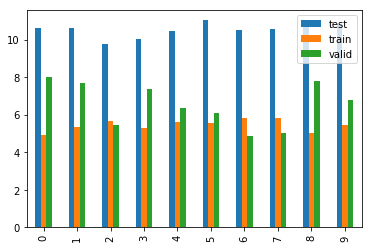

----------------------------
----------------------------
 Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) 



test     10.431454
train     5.543108
valid     6.607488
dtype: float64

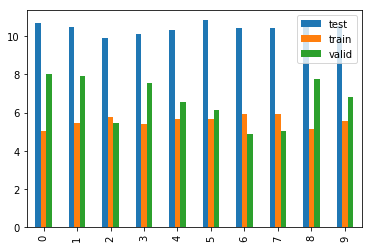

----------------------------
----------------------------
 Ridge(alpha=30, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) 



test     10.428931
train     5.640493
valid     6.702254
dtype: float64

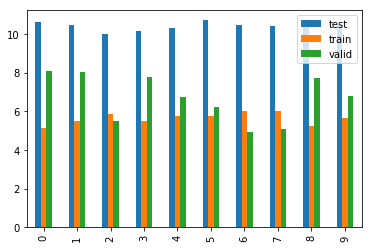

----------------------------
----------------------------
 Ridge(alpha=40, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) 



test     10.459026
train     5.746442
valid     6.809808
dtype: float64

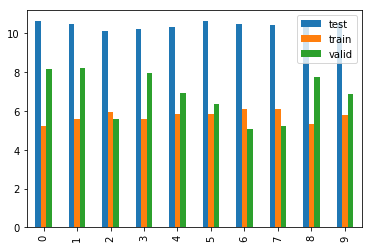

----------------------------
----------------------------
 Ridge(alpha=50, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) 



test     10.510586
train     5.858019
valid     6.923311
dtype: float64

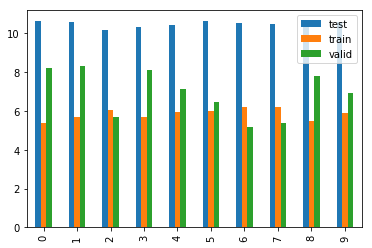

----------------------------
----------------------------
 Ridge(alpha=60, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) 



test     10.577172
train     5.973295
valid     7.039965
dtype: float64

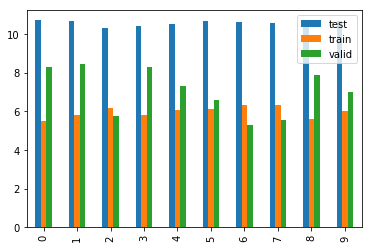

----------------------------
----------------------------
 Ridge(alpha=70, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) 



test     10.654362
train     6.090908
valid     7.158285
dtype: float64

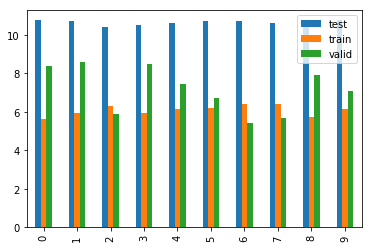

----------------------------
----------------------------
 Ridge(alpha=80, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) 



test     10.739005
train     6.209850
valid     7.277339
dtype: float64

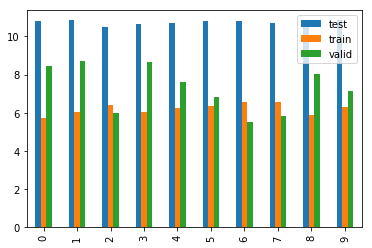

----------------------------
----------------------------
 Ridge(alpha=90, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) 



test     10.828813
train     6.329349
valid     7.396475
dtype: float64

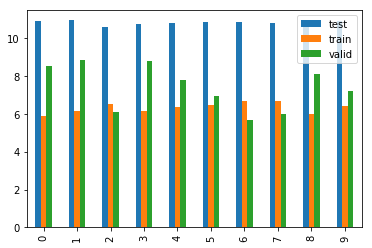

----------------------------
----------------------------
 Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) 



test     10.922098
train     6.448806
valid     7.515211
dtype: float64

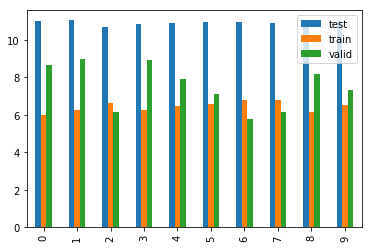

----------------------------


In [391]:
min_error = np.inf
best_model = None
for model in models_factory(Ridge, alpha=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fit_intercept=[True]):
    df_err = assess(model)
    test_err = df_err.test.mean()
    if test_err < min_error:
        min_error = test_err
        best_model = model

In [392]:
best_model

Ridge(alpha=30, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)